# Logistic Regression from Scratch
Binary classification on the **Glass dataset** — predicting whether a glass sample is Type 1 or not.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load & Explore Data

In [4]:
# Load the glass datasetglass_df
from google.colab import files
glass_df =  files.upload()  # click 'Choose Files' and select glass.csv
glass_df = pd.read_csv('glass.csv')

# Display the first few rows of the dataset
glass_df.head()

Saving glass.csv to glass (1).csv


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [5]:
# Column names and data types
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


**Features:** RI, Na, Mg, Al, Si, K, Ca, Ba, Fe — all numerical.

**Target:** `Type` — 6 distinct glass types → multiclass, but we convert to **binary** (Type 1 vs rest).

In [6]:
# Check unique glass types
print('Unique glass types:', np.unique(glass_df['Type']))

Unique glass types: [1 2 3 5 6 7]


## 2. Prepare Binary Target & Feature Matrix

In [7]:
# Binary target: 1 if Type == 1, else 0
glass_df['is_type1'] = (glass_df['Type'] == 1).astype(int)
glass_df = glass_df.drop(columns=['Type'])

print('Target value counts:')
print(glass_df['is_type1'].value_counts())

Target value counts:
is_type1
0    144
1     70
Name: count, dtype: int64


In [8]:
# Separate features and target
X = glass_df.drop(columns=['is_type1']).values
y = glass_df['is_type1'].values

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (214, 9)
y shape: (214,)


## 3. Train-Test Split

In [9]:
import random

def train_test_split_custom(X, y, test_size=0.3, random_seed=None):
    """Shuffle and split data into train/test sets."""
    paired_data = list(zip(X, y))   # pair each sample with its label

    if random_seed is not None:
        random.seed(random_seed)        # fix seed for reproducibility
    random.shuffle(paired_data)

    split_idx = int(len(paired_data) * (1 - test_size))
    train_data = paired_data[:split_idx]
    test_data  = paired_data[split_idx:]

    X_train, y_train = zip(*train_data)
    X_test,  y_test  = zip(*test_data)

    return (
        np.array(X_train), np.array(X_test),
        np.array(y_train), np.array(y_test)
    )


X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_size=0.2, random_seed=42)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])

Train size: 171 | Test size: 43


## 4. Feature Scaling
Standard Scaler: $z = \frac{x - \mu}{\sigma}$

> **Fit only on training data** to avoid data leakage — then transform both train and test.

In [10]:
class StandardScaler:
    """Standardize features to zero mean and unit variance."""

    def __init__(self):
        self.mean_ = None
        self.std_  = None

    def fit(self, X):
        X = np.array(X)
        self.mean_ = X.mean(axis=0)
        self.std_  = X.std(axis=0)

    def transform(self, X):
        X = np.array(X)
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X_scaled):
        return np.array(X_scaled) * self.std_ + self.mean_


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit + transform on train
X_test_scaled  = scaler.transform(X_test)        # transform only on test

print('Before scaling (first sample):', X_train[0])
print('After  scaling (first sample):', X_train_scaled[0].round(4))

Before scaling (first sample): [ 1.51658 14.8      0.       1.99    73.11     0.       8.28     1.71
  0.     ]
After  scaling (first sample): [-0.6035  1.7952 -1.8886  1.1044  0.6078 -0.7204 -0.499   3.3019 -0.5905]


## 5. Logistic Regression Model
Implements sigmoid activation, binary cross-entropy loss, and gradient descent.

In [11]:
def sigmoid(z):
    """Sigmoid activation: maps any real number to (0, 1)."""
    return 1 / (1 + np.exp(-z))


def predict_proba(X, weights, bias):
    """Compute predicted probabilities using current weights and bias."""
    linear_output = np.dot(X, weights) + bias
    return sigmoid(linear_output)


def binary_cross_entropy(y_true, y_prob):
    """Binary cross-entropy loss."""
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))


def gradient_descent_step(X, y_true, weights, bias, learning_rate):
    """Perform one gradient descent update and return updated weights and bias."""
    y_prob = predict_proba(X, weights, bias)
    error  = y_prob - y_true                     # residuals

    grad_weights = np.dot(X.T, error) / len(y_true)
    grad_bias    = np.mean(error)

    weights = weights - learning_rate * grad_weights
    bias    = bias    - learning_rate * grad_bias
    return weights, bias


def predict(X, weights, bias, threshold=0.5):
    """Return binary class labels based on predicted probabilities."""
    y_prob = predict_proba(X, weights, bias)
    return (y_prob >= threshold).astype(int)

## 6. Train the Model

In [12]:
# Hyperparameters
learning_rate = 0.1
num_epochs    = 100

# Initialize weights and bias
weights = np.zeros(X_train_scaled.shape[1])
bias    = 0.0

# Training loop
loss_history = []
for epoch in range(num_epochs):
    weights, bias = gradient_descent_step(X_train_scaled, y_train, weights, bias, learning_rate)
    current_loss  = binary_cross_entropy(y_train, predict_proba(X_train_scaled, weights, bias))
    loss_history.append(current_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1:>3}/{num_epochs}  |  Loss: {current_loss:.4f}')

Epoch  10/100  |  Loss: 0.6110
Epoch  20/100  |  Loss: 0.5707
Epoch  30/100  |  Loss: 0.5466
Epoch  40/100  |  Loss: 0.5304
Epoch  50/100  |  Loss: 0.5187
Epoch  60/100  |  Loss: 0.5098
Epoch  70/100  |  Loss: 0.5028
Epoch  80/100  |  Loss: 0.4972
Epoch  90/100  |  Loss: 0.4925
Epoch 100/100  |  Loss: 0.4885


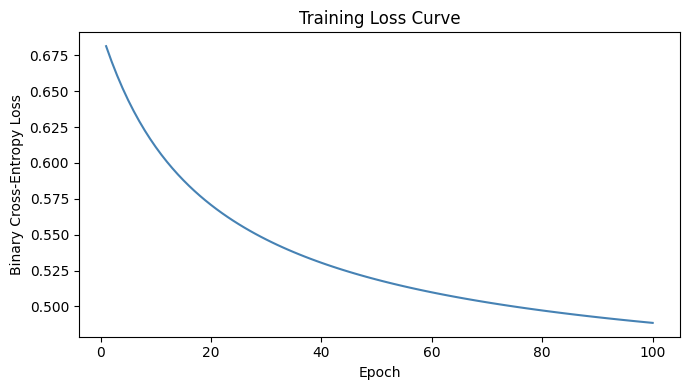

In [13]:
# Plot training loss curve
plt.figure(figsize=(7, 4))
plt.plot(range(1, num_epochs + 1), loss_history, color='steelblue')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training Loss Curve')
plt.tight_layout()
plt.show()

## 7. Evaluate on Test Set

In [14]:
for threshold in [0.5, 0.6, 0.7, 0.8]:
    y_pred    = predict(X_test_scaled, weights, bias, threshold=threshold)
    accuracy  = np.mean(y_pred == y_test)
    print(f'Threshold {threshold:.1f}  |  Test Accuracy: {accuracy:.4f}')

Threshold 0.5  |  Test Accuracy: 0.6744
Threshold 0.6  |  Test Accuracy: 0.6512
Threshold 0.7  |  Test Accuracy: 0.6512
Threshold 0.8  |  Test Accuracy: 0.6047
